In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

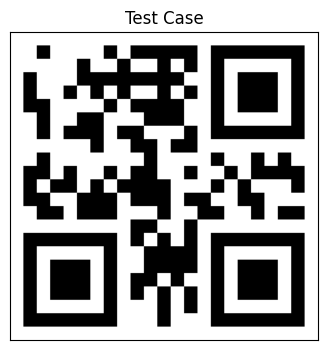

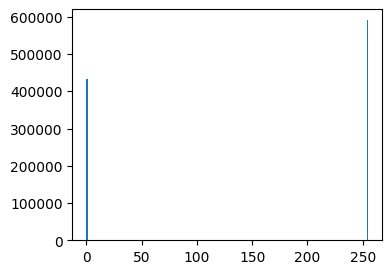

In [3]:
test_case = "test_data/3_rotated.png"
img = cv2.imread(test_case, cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(4, 4))
plt.xticks([], [])
plt.yticks([], [])
plt.title("Test Case")
plt.imshow(img, cmap="gray")

plt.figure(figsize=(4, 3))
plt.hist(img.ravel(), bins=256);

## Rotation Fix

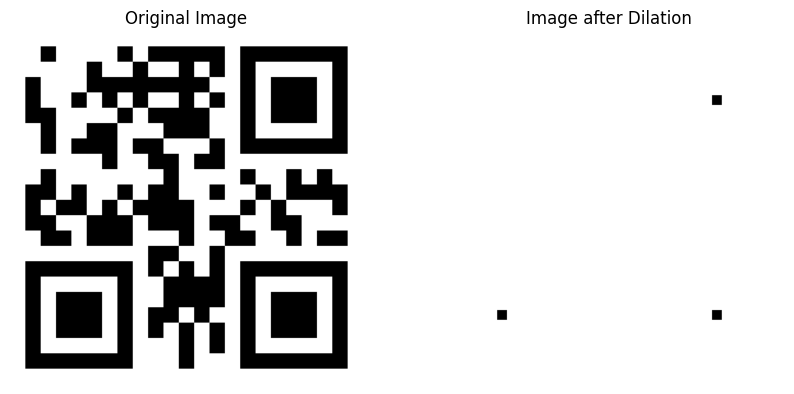

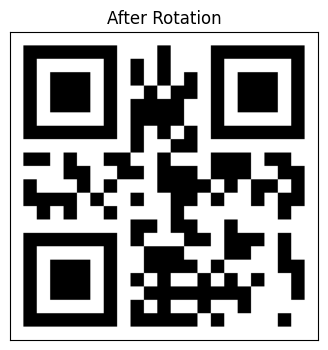

In [4]:
temp_img = img.copy()

# dilate to isolate black corners
custom_kernel_size = 105
custom_kernel = np.ones((custom_kernel_size, custom_kernel_size), dtype=np.uint8)
temp_img = cv2.dilate(temp_img, custom_kernel, iterations=1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(temp_img, cmap="gray")
plt.title("Image after Dilation")
plt.axis("off")

plt.show()


# Load the image in grayscale and apply thresholding to create a binary image
_, binary = cv2.threshold(temp_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform connected component analysis (CCA) to label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    binary, connectivity=8
)

# loop to check on orientation
rotation_flags = [0, 0, 0, 0]
for i in range(1, num_labels):  # Skip the background label (0)
    x, y, _, _, _ = stats[i]
    if x < img.shape[0] / 2 and y < img.shape[0] / 2:
        rotation_flags[0] = 1
    elif x > img.shape[0] / 2 and y < img.shape[0] / 2:
        rotation_flags[1] = 1
    elif x < img.shape[0] / 2 and y > img.shape[0] / 2:
        rotation_flags[2] = 1
    elif x > img.shape[0] / 2 and y > img.shape[0] / 2:
        rotation_flags[3] = 1

# check orientation and do optimal rotation movements
if rotation_flags == [1, 1, 1, 0]:
    rotated_image = img
elif rotation_flags == [1, 0, 1, 1]:
    rotated_image = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
elif rotation_flags == [0, 1, 1, 1]:
    rotated_image = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
elif rotation_flags == [1, 1, 0, 1]:
    rotated_image = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
else:
    rotated_image = img

img = rotated_image
fig = plt.figure(figsize=(4, 4))
plt.xticks([], [])
plt.yticks([], [])
plt.title("After Rotation")
plt.imshow(img, cmap="gray");

In [5]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print(start_row, end_row, start_col, end_col)

44 968 44 968


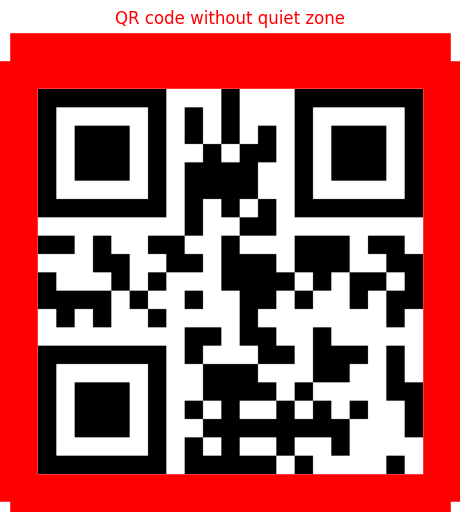

In [6]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
fig.get_axes()[0].spines[:].set_color("red")
fig.get_axes()[0].spines[:].set_linewidth(40)
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title("QR code without quiet zone", y=1.15, color="red")
plt.imshow(qr_no_quiet_zone, cmap="gray");

In [7]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if pixel != 0:
        break
    size += 1

print(size)

308


In [8]:
# Therefore the grid cell size is..
grid_cell_size = round(size / 7)
print(grid_cell_size)

44


In [9]:
# And it each row/column is expected to have the following no. of qr_cells
grid_cells_num = round(qr_no_quiet_zone.shape[0] / grid_cell_size)
print(grid_cells_num)

21


In [10]:
# So now it is time to split the following shape...
print(qr_no_quiet_zone.shape)

(924, 924)


In [11]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape(
    (
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )
).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 44, 44)


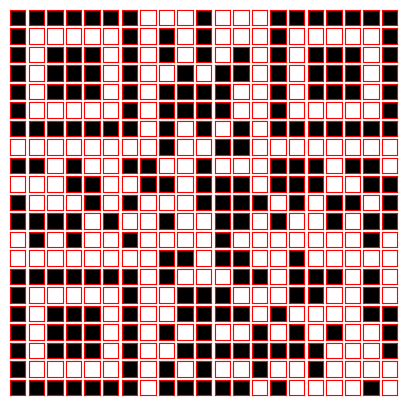

In [12]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color("red")

In [13]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = np.median(cell) // 255

print(qr_cells_numeric)

[[0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1]
 [1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0]
 [0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0]
 [0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0]
 [1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1]
 [0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1]
 [0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0]
 [0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0]
 [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1]]


In [14]:
# We want row #8
qr_cells_numeric[8]

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1],
      dtype=uint8)

In [15]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not (c)) for c in qr_cells_numeric[8, 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)

[1, 1]


In [16]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not (c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = "".join([str(c) for c in mask])
print(mask_str)

010


In [17]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not (c)) for c in fec]
print(fec)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


In [18]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [0, 1, 0] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


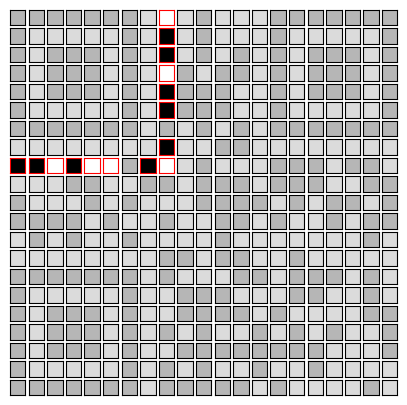

In [19]:
# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color("red")
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

In [20]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [1, 1, 1] [0, 1, 0, 1, 1, 1, 1, 1, 0, 0]


In [21]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"


def apply_mask(data_start_i, data_start_j, direction):
    """
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    """
    result = []
    row_offsets = []
    col_offsets = []
    if direction in [UP, UP_ENC]:
        row_offsets = [0, 0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
    if direction == DOWN:
        row_offsets = [0, 0, 1, 1, 2, 2, 3, 3]
        col_offsets = [0, -1, 0, -1, 0, -1, 0, -1]
    if direction == CW:
        row_offsets = [0, 0, 1, 1, 1, 1, 0, 0]
        col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]
    if direction == CCW:
        row_offsets = [0, 0, -1, -1, -1, -1, 0, 0]
        col_offsets = [0, -1, 0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i + i, data_start_j + j]
        result.append(
            int(
                cell
                if MASKS[mask_str](data_start_i + i, data_start_j + j)
                else not cell
            )
        )

    return result[:4] if direction == UP_ENC else result

In [22]:
enc = apply_mask(grid_cells_num - 1, grid_cells_num - 1, UP_ENC)
print(enc)

[0, 1, 0, 0]


In [23]:
len = apply_mask(grid_cells_num - 3, grid_cells_num - 1, UP)
print(len)

[0, 0, 0, 1, 0, 0, 0, 0]


In [24]:
data_starting_indices = [
    [grid_cells_num - 7, grid_cells_num - 1, UP],
    [grid_cells_num - 11, grid_cells_num - 1, CCW],
    [grid_cells_num - 10, grid_cells_num - 3, DOWN],
    [grid_cells_num - 6, grid_cells_num - 3, DOWN],
    [grid_cells_num - 2, grid_cells_num - 3, CW],
    [grid_cells_num - 3, grid_cells_num - 5, UP],
    [grid_cells_num - 7, grid_cells_num - 5, UP],
    [grid_cells_num - 11, grid_cells_num - 5, CCW],
    [grid_cells_num - 10, grid_cells_num - 7, DOWN],
    [grid_cells_num - 6, grid_cells_num - 7, DOWN],
    [grid_cells_num - 2, grid_cells_num - 7, CW],
    [grid_cells_num - 3, grid_cells_num - 9, UP],
    [grid_cells_num - 7, grid_cells_num - 9, UP],
    [grid_cells_num - 11, grid_cells_num - 9, UP],
    [grid_cells_num - 16, grid_cells_num - 9, UP],
    [grid_cells_num - 20, grid_cells_num - 9, CCW],
    [grid_cells_num - 19, grid_cells_num - 11, DOWN],
    [grid_cells_num - 14, grid_cells_num - 11, DOWN],
    [grid_cells_num - 10, grid_cells_num - 11, DOWN],
    [grid_cells_num - 6, grid_cells_num - 11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
]

ans = ""
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = "".join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f"{bit_string[:4]} = 0 (NULL TERMINATOR)")
        break
    ans += chr(int(bit_string, 2))  # converts to binary to int, then to ASCII
    print(f"{bit_string} = {ans[-1]}")

print(f"\nDecoded string: {ans}")

01001100 = L
01100101 = e
01100110 = f
01100110 = f
01111001 = y
01000010 = B
01101001 = i
01101110 = n
01100001 = a
01011001 = Y
01100001 = a
01000100 = D
01101111 = o
01101110 = n
01111001 = y
01100001 = a
0000 = 0 (NULL TERMINATOR)

Decoded string: LeffyBinaYaDonya
